In [28]:
import bayes3d as b
import bayes3d.genjax
import genjax
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import jax.tree_util as jtu
import numpy as np
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import Diff
import trimesh
console = genjax.pretty(show_locals=False)

In [2]:
intrinsics = b.Intrinsics(
    height=1,
    width=50,
    fx=10.0, fy=1.0,
    cx=25.0, cy=0.0,
    near=0.01, far=20.0
)
b.setup_renderer(intrinsics)

Increasing frame buffer size to (width, height, depth) = (64, 32, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7009/static/


In [4]:
env_data = {
    "env_name": "014e6d1cee6e6a1297a78f761fbc6700.json",
    "paths": [
        [
            [
                15.13554761904762,
                14.694047619047623
            ],
            [
                14.821214285714289,
                14.604238095238099
            ],
            [
                14.551785714285716,
                14.469523809523814
            ],
            [
                14.372166666666667,
                14.245000000000005
            ],
            [
                14.237452380952382,
                13.975571428571431
            ],
            [
                14.102738095238097,
                13.706142857142861
            ],
            [
                14.057833333333337,
                13.346904761904764
            ],
            [
                14.012928571428573,
                13.077476190476194
            ],
            [
                13.878214285714288,
                12.80804761904762
            ],
            [
                13.788404761904763,
                12.359000000000002
            ],
            [
                13.608785714285714,
                11.999761904761908
            ],
            [
                13.518976190476193,
                11.685428571428574
            ],
            [
                13.47407142857143,
                11.371095238095242
            ],
            [
                13.384261904761905,
                11.056761904761908
            ],
            [
                13.24954761904762,
                10.787333333333336
            ],
            [
                12.890309523809526,
                10.60771428571429
            ],
            [
                12.665785714285716,
                10.60771428571429
            ],
            [
                12.261642857142858,
                10.562809523809527
            ],
            [
                11.8575,
                10.517904761904765
            ],
            [
                11.408452380952381,
                10.473000000000003
            ],
            [
                10.9145,
                10.473000000000003
            ],
            [
                10.42054761904762,
                10.473000000000003
            ],
            [
                10.061309523809525,
                10.42809523809524
            ],
            [
                9.567357142857144,
                10.473000000000003
            ],
            [
                9.118309523809524,
                10.473000000000003
            ],
            [
                8.714166666666667,
                10.473000000000003
            ],
            [
                8.175309523809524,
                10.60771428571429
            ],
            [
                7.726261904761905,
                10.87714285714286
            ],
            [
                7.367023809523809,
                11.281285714285717
            ],
            [
                7.187404761904762,
                11.730333333333336
            ],
            [
                7.052690476190477,
                12.224285714285717
            ],
            [
                7.052690476190477,
                12.673333333333336
            ],
            [
                7.097595238095238,
                12.942761904761909
            ],
            [
                7.187404761904762,
                13.302000000000003
            ],
            [
                7.2323095238095245,
                13.706142857142861
            ],
            [
                7.097595238095238,
                14.065380952380956
            ],
            [
                6.917976190476191,
                14.42461904761905
            ],
            [
                6.558738095238095,
                14.694047619047623
            ],
            [
                6.019880952380953,
                14.918571428571433
            ],
            [
                5.660642857142857,
                15.143095238095242
            ],
            [
                5.256500000000001,
                15.367619047619051
            ],
            [
                5.076880952380952,
                15.59214285714286
            ],
            [
                4.852357142857143,
                15.81666666666667
            ],
            [
                4.582928571428571,
                16.22080952380953
            ],
            [
                4.3134999999999994,
                16.580047619047622
            ],
            [
                3.954261904761905,
                16.75966666666667
            ],
            [
                3.550119047619047,
                16.939285714285717
            ],
            [
                3.1459761904761905,
                17.02909523809524
            ],
            [
                2.741833333333333,
                17.02909523809524
            ],
            [
                2.2927857142857135,
                17.074000000000005
            ],
            [
                1.8437380952380948,
                16.98419047619048
            ]
        ],
        [
            [
                18.278880952380952,
                14.514428571428574
            ],
            [
                17.91964285714286,
                14.334809523809525
            ],
            [
                17.515500000000003,
                14.110285714285716
            ],
            [
                17.290976190476194,
                13.795952380952386
            ],
            [
                17.156261904761905,
                13.571428571428573
            ],
            [
                16.931738095238096,
                13.122380952380954
            ],
            [
                16.662309523809526,
                12.583523809523811
            ],
            [
                16.572500000000005,
                12.26919047619048
            ],
            [
                16.527595238095238,
                11.909952380952383
            ],
            [
                16.437785714285717,
                11.550714285714289
            ],
            [
                16.437785714285717,
                11.191476190476193
            ],
            [
                16.303071428571428,
                10.832238095238099
            ],
            [
                15.854023809523811,
                10.562809523809527
            ],
            [
                15.539690476190477,
                10.473000000000003
            ],
            [
                14.955928571428574,
                10.42809523809524
            ],
            [
                14.41707142857143,
                10.42809523809524
            ],
            [
                13.833309523809524,
                10.338285714285718
            ],
            [
                13.339357142857144,
                10.42809523809524
            ],
            [
                12.800500000000001,
                10.473000000000003
            ],
            [
                12.306547619047619,
                10.383190476190478
            ],
            [
                11.8575,
                10.383190476190478
            ],
            [
                11.453357142857143,
                10.42809523809524
            ],
            [
                10.9145,
                10.42809523809524
            ],
            [
                10.510357142857144,
                10.473000000000003
            ],
            [
                10.151119047619048,
                10.42809523809524
            ],
            [
                9.746976190476191,
                10.42809523809524
            ],
            [
                9.208119047619048,
                10.473000000000003
            ],
            [
                8.53454761904762,
                10.473000000000003
            ],
            [
                8.130404761904762,
                10.742428571428574
            ],
            [
                7.636452380952381,
                11.371095238095242
            ],
            [
                7.411928571428572,
                11.865047619047623
            ],
            [
                7.187404761904762,
                12.583523809523811
            ],
            [
                7.1425,
                13.167285714285718
            ],
            [
                7.097595238095238,
                13.706142857142861
            ],
            [
                7.052690476190477,
                14.20009523809524
            ],
            [
                7.007785714285715,
                14.604238095238099
            ],
            [
                6.648547619047619,
                15.053285714285717
            ]
        ],
        [
            [
                14.821214285714289,
                14.604238095238099
            ],
            [
                14.461976190476191,
                14.42461904761905
            ],
            [
                14.147642857142857,
                14.020476190476195
            ],
            [
                13.923119047619048,
                13.481619047619052
            ],
            [
                13.743500000000003,
                12.80804761904762
            ],
            [
                13.608785714285714,
                12.179380952380955
            ],
            [
                13.518976190476193,
                11.640523809523813
            ],
            [
                13.47407142857143,
                11.191476190476193
            ],
            [
                13.384261904761905,
                10.832238095238099
            ],
            [
                13.02502380952381,
                10.562809523809527
            ],
            [
                12.261642857142858,
                10.517904761904765
            ],
            [
                11.8575,
                11.056761904761908
            ],
            [
                11.767690476190479,
                11.82014285714286
            ],
            [
                11.722785714285715,
                12.403904761904766
            ],
            [
                11.58807142857143,
                13.122380952380954
            ],
            [
                11.408452380952381,
                13.751047619047622
            ],
            [
                11.09411904761905,
                14.334809523809525
            ],
            [
                10.555261904761906,
                14.64914285714286
            ]
        ],
        []
    ],
    "verts": [
        [
            13.24,
            0.1
        ],
        [
            13.23,
            0.11
        ],
        [
            13.23,
            5.67
        ],
        [
            13.31,
            5.67
        ],
        [
            13.32,
            5.68
        ],
        [
            13.32,
            5.78
        ],
        [
            13.31,
            5.79
        ],
        [
            12.24,
            5.79
        ],
        [
            12.23,
            5.8
        ],
        [
            12.23,
            9.57
        ],
        [
            14.52,
            9.57
        ],
        [
            14.53,
            9.58
        ],
        [
            14.53,
            9.68
        ],
        [
            14.52,
            9.69
        ],
        [
            8.93,
            9.69
        ],
        [
            8.93,
            9.85
        ],
        [
            8.92,
            9.86
        ],
        [
            8.82,
            9.86
        ],
        [
            8.81,
            9.85
        ],
        [
            8.81,
            9.69
        ],
        [
            5.98,
            9.69
        ],
        [
            5.97,
            9.7
        ],
        [
            5.96,
            9.7
        ],
        [
            5.95,
            9.69
        ],
        [
            5.63,
            9.69
        ],
        [
            5.62,
            9.68
        ],
        [
            5.62,
            9.58
        ],
        [
            5.63,
            9.57
        ],
        [
            5.87,
            9.57
        ],
        [
            5.87,
            5.79
        ],
        [
            1.94,
            5.79
        ],
        [
            1.93,
            5.8
        ],
        [
            1.93,
            9.07
        ],
        [
            4.51,
            9.07
        ],
        [
            4.53,
            9.09
        ],
        [
            4.53,
            9.57
        ],
        [
            4.77,
            9.57
        ],
        [
            4.78,
            9.58
        ],
        [
            4.78,
            9.68
        ],
        [
            4.77,
            9.69
        ],
        [
            4.53,
            9.69
        ],
        [
            4.53,
            10.14
        ],
        [
            4.52,
            10.15
        ],
        [
            4.42,
            10.15
        ],
        [
            4.41,
            10.14
        ],
        [
            4.41,
            9.19
        ],
        [
            1.93,
            9.19
        ],
        [
            1.93,
            11.07
        ],
        [
            4.41,
            11.07
        ],
        [
            4.41,
            11.0
        ],
        [
            4.42,
            10.99
        ],
        [
            4.52,
            10.99
        ],
        [
            4.53,
            11.0
        ],
        [
            4.53,
            11.07
        ],
        [
            5.32,
            11.07
        ],
        [
            5.33,
            11.06
        ],
        [
            5.33,
            11.05
        ],
        [
            5.34,
            11.04
        ],
        [
            5.36,
            11.04
        ],
        [
            5.37,
            11.05
        ],
        [
            5.38,
            11.05
        ],
        [
            5.39,
            11.06
        ],
        [
            5.4,
            11.06
        ],
        [
            5.41,
            11.07
        ],
        [
            5.42,
            11.07
        ],
        [
            5.43,
            11.08
        ],
        [
            5.44,
            11.08
        ],
        [
            5.45,
            11.09
        ],
        [
            5.43,
            11.11
        ],
        [
            5.43,
            11.18
        ],
        [
            5.42,
            11.19
        ],
        [
            5.42,
            13.57
        ],
        [
            6.46,
            13.57
        ],
        [
            6.47,
            13.58
        ],
        [
            6.47,
            13.68
        ],
        [
            6.46,
            13.69
        ],
        [
            4.19,
            13.69
        ],
        [
            4.18,
            13.68
        ],
        [
            4.18,
            13.58
        ],
        [
            4.19,
            13.57
        ],
        [
            5.31,
            13.57
        ],
        [
            5.31,
            11.19
        ],
        [
            1.93,
            11.19
        ],
        [
            1.93,
            13.57
        ],
        [
            3.23,
            13.57
        ],
        [
            3.24,
            13.58
        ],
        [
            3.24,
            13.68
        ],
        [
            3.23,
            13.69
        ],
        [
            1.89,
            13.69
        ],
        [
            1.88,
            13.7
        ],
        [
            1.87,
            13.7
        ],
        [
            1.85,
            13.72
        ],
        [
            1.84,
            13.72
        ],
        [
            1.82,
            13.74
        ],
        [
            1.81,
            13.74
        ],
        [
            1.79,
            13.76
        ],
        [
            1.78,
            13.76
        ],
        [
            1.76,
            13.78
        ],
        [
            1.75,
            13.78
        ],
        [
            1.73,
            13.8
        ],
        [
            1.72,
            13.8
        ],
        [
            1.71,
            13.81
        ],
        [
            1.7,
            13.81
        ],
        [
            1.68,
            13.83
        ],
        [
            1.67,
            13.83
        ],
        [
            1.65,
            13.85
        ],
        [
            1.64,
            13.85
        ],
        [
            1.62,
            13.87
        ],
        [
            1.61,
            13.87
        ],
        [
            1.59,
            13.89
        ],
        [
            1.58,
            13.89
        ],
        [
            1.56,
            13.91
        ],
        [
            1.55,
            13.91
        ],
        [
            1.53,
            13.93
        ],
        [
            1.52,
            13.93
        ],
        [
            1.5,
            13.95
        ],
        [
            1.49,
            13.95
        ],
        [
            1.47,
            13.97
        ],
        [
            1.46,
            13.97
        ],
        [
            1.44,
            13.99
        ],
        [
            1.43,
            13.99
        ],
        [
            1.41,
            14.01
        ],
        [
            1.4,
            14.01
        ],
        [
            1.38,
            14.03
        ],
        [
            1.37,
            14.03
        ],
        [
            1.35,
            14.05
        ],
        [
            1.34,
            14.05
        ],
        [
            1.32,
            14.07
        ],
        [
            1.31,
            14.07
        ],
        [
            1.29,
            14.09
        ],
        [
            1.28,
            14.09
        ],
        [
            1.27,
            14.1
        ],
        [
            1.26,
            14.1
        ],
        [
            1.24,
            14.12
        ],
        [
            1.23,
            14.12
        ],
        [
            1.21,
            14.14
        ],
        [
            1.2,
            14.14
        ],
        [
            1.18,
            14.16
        ],
        [
            1.17,
            14.16
        ],
        [
            1.15,
            14.18
        ],
        [
            1.14,
            14.18
        ],
        [
            1.12,
            14.2
        ],
        [
            1.11,
            14.2
        ],
        [
            1.09,
            14.22
        ],
        [
            1.08,
            14.22
        ],
        [
            1.06,
            14.24
        ],
        [
            1.05,
            14.24
        ],
        [
            1.03,
            14.26
        ],
        [
            1.02,
            14.26
        ],
        [
            1.0,
            14.28
        ],
        [
            0.99,
            14.28
        ],
        [
            0.97,
            14.3
        ],
        [
            0.96,
            14.3
        ],
        [
            0.94,
            14.32
        ],
        [
            0.93,
            14.32
        ],
        [
            0.91,
            14.34
        ],
        [
            0.9,
            14.34
        ],
        [
            0.88,
            14.36
        ],
        [
            0.87,
            14.36
        ],
        [
            0.85,
            14.38
        ],
        [
            0.84,
            14.38
        ],
        [
            0.83,
            14.39
        ],
        [
            0.82,
            14.39
        ],
        [
            0.8,
            14.41
        ],
        [
            0.79,
            14.41
        ],
        [
            0.77,
            14.43
        ],
        [
            0.76,
            14.43
        ],
        [
            0.74,
            14.45
        ],
        [
            0.73,
            14.45
        ],
        [
            0.71,
            14.47
        ],
        [
            0.7,
            14.47
        ],
        [
            0.68,
            14.49
        ],
        [
            0.67,
            14.49
        ],
        [
            0.65,
            14.51
        ],
        [
            0.64,
            14.51
        ],
        [
            0.62,
            14.53
        ],
        [
            0.61,
            14.53
        ],
        [
            0.59,
            14.55
        ],
        [
            0.58,
            14.55
        ],
        [
            0.56,
            14.57
        ],
        [
            0.55,
            14.57
        ],
        [
            0.53,
            14.59
        ],
        [
            0.52,
            14.59
        ],
        [
            0.5,
            14.61
        ],
        [
            0.49,
            14.61
        ],
        [
            0.47,
            14.63
        ],
        [
            0.46,
            14.63
        ],
        [
            0.44,
            14.65
        ],
        [
            0.43,
            14.65
        ],
        [
            0.41,
            14.67
        ],
        [
            0.4,
            14.67
        ],
        [
            0.39,
            14.68
        ],
        [
            0.38,
            14.68
        ],
        [
            0.36,
            14.7
        ],
        [
            0.35,
            14.7
        ],
        [
            0.33,
            14.72
        ],
        [
            0.32,
            14.72
        ],
        [
            0.3,
            14.74
        ],
        [
            0.29,
            14.74
        ],
        [
            0.27,
            14.76
        ],
        [
            0.26,
            14.76
        ],
        [
            0.24,
            14.78
        ],
        [
            0.23,
            14.78
        ],
        [
            0.21,
            14.8
        ],
        [
            0.2,
            14.8
        ],
        [
            0.18,
            14.82
        ],
        [
            0.17,
            14.82
        ],
        [
            0.15,
            14.84
        ],
        [
            0.14,
            14.84
        ],
        [
            0.12,
            14.86
        ],
        [
            0.11,
            14.86
        ],
        [
            0.1,
            14.87
        ],
        [
            0.1,
            17.78
        ],
        [
            0.11,
            17.79
        ],
        [
            0.12,
            17.79
        ],
        [
            0.14,
            17.81
        ],
        [
            0.15,
            17.81
        ],
        [
            0.17,
            17.83
        ],
        [
            0.18,
            17.83
        ],
        [
            0.2,
            17.85
        ],
        [
            0.21,
            17.85
        ],
        [
            0.23,
            17.87
        ],
        [
            0.24,
            17.87
        ],
        [
            0.26,
            17.89
        ],
        [
            0.27,
            17.89
        ],
        [
            0.29,
            17.91
        ],
        [
            0.3,
            17.91
        ],
        [
            0.32,
            17.93
        ],
        [
            0.33,
            17.93
        ],
        [
            0.35,
            17.95
        ],
        [
            0.36,
            17.95
        ],
        [
            0.38,
            17.97
        ],
        [
            0.39,
            17.97
        ],
        [
            0.41,
            17.99
        ],
        [
            0.42,
            17.99
        ],
        [
            0.44,
            18.01
        ],
        [
            0.45,
            18.01
        ],
        [
            0.47,
            18.03
        ],
        [
            0.48,
            18.03
        ],
        [
            0.5,
            18.05
        ],
        [
            0.51,
            18.05
        ],
        [
            0.53,
            18.07
        ],
        [
            0.54,
            18.07
        ],
        [
            0.56,
            18.09
        ],
        [
            0.57,
            18.09
        ],
        [
            0.59,
            18.11
        ],
        [
            0.6,
            18.11
        ],
        [
            0.62,
            18.13
        ],
        [
            0.63,
            18.13
        ],
        [
            0.65,
            18.15
        ],
        [
            0.66,
            18.15
        ],
        [
            0.68,
            18.17
        ],
        [
            0.69,
            18.17
        ],
        [
            0.71,
            18.19
        ],
        [
            0.72,
            18.19
        ],
        [
            0.74,
            18.21
        ],
        [
            0.75,
            18.21
        ],
        [
            0.77,
            18.23
        ],
        [
            0.78,
            18.23
        ],
        [
            0.8,
            18.25
        ],
        [
            0.81,
            18.25
        ],
        [
            0.83,
            18.27
        ],
        [
            0.84,
            18.27
        ],
        [
            0.86,
            18.29
        ],
        [
            0.87,
            18.29
        ],
        [
            0.89,
            18.31
        ],
        [
            0.9,
            18.31
        ],
        [
            0.91,
            18.32
        ],
        [
            0.92,
            18.32
        ],
        [
            0.94,
            18.34
        ],
        [
            0.95,
            18.34
        ],
        [
            0.97,
            18.36
        ],
        [
            0.98,
            18.36
        ],
        [
            1.0,
            18.38
        ],
        [
            1.01,
            18.38
        ],
        [
            1.03,
            18.4
        ],
        [
            1.04,
            18.4
        ],
        [
            1.06,
            18.42
        ],
        [
            1.07,
            18.42
        ],
        [
            1.09,
            18.44
        ],
        [
            1.1,
            18.44
        ],
        [
            1.12,
            18.46
        ],
        [
            1.13,
            18.46
        ],
        [
            1.15,
            18.48
        ],
        [
            1.16,
            18.48
        ],
        [
            1.18,
            18.5
        ],
        [
            1.19,
            18.5
        ],
        [
            1.21,
            18.52
        ],
        [
            1.22,
            18.52
        ],
        [
            1.24,
            18.54
        ],
        [
            1.25,
            18.54
        ],
        [
            1.27,
            18.56
        ],
        [
            1.28,
            18.56
        ],
        [
            1.3,
            18.58
        ],
        [
            1.31,
            18.58
        ],
        [
            1.33,
            18.6
        ],
        [
            1.34,
            18.6
        ],
        [
            1.36,
            18.62
        ],
        [
            1.37,
            18.62
        ],
        [
            1.39,
            18.64
        ],
        [
            1.4,
            18.64
        ],
        [
            1.42,
            18.66
        ],
        [
            1.43,
            18.66
        ],
        [
            1.45,
            18.68
        ],
        [
            1.46,
            18.68
        ],
        [
            1.48,
            18.7
        ],
        [
            1.49,
            18.7
        ],
        [
            1.51,
            18.72
        ],
        [
            1.52,
            18.72
        ],
        [
            1.54,
            18.74
        ],
        [
            1.55,
            18.74
        ],
        [
            1.57,
            18.76
        ],
        [
            1.58,
            18.76
        ],
        [
            1.6,
            18.78
        ],
        [
            1.61,
            18.78
        ],
        [
            1.63,
            18.8
        ],
        [
            1.64,
            18.8
        ],
        [
            1.66,
            18.82
        ],
        [
            1.67,
            18.82
        ],
        [
            1.69,
            18.84
        ],
        [
            1.7,
            18.84
        ],
        [
            1.72,
            18.86
        ],
        [
            1.73,
            18.86
        ],
        [
            1.75,
            18.88
        ],
        [
            1.76,
            18.88
        ],
        [
            1.78,
            18.9
        ],
        [
            1.79,
            18.9
        ],
        [
            1.81,
            18.92
        ],
        [
            1.82,
            18.92
        ],
        [
            1.84,
            18.94
        ],
        [
            1.85,
            18.94
        ],
        [
            1.87,
            18.96
        ],
        [
            8.8,
            18.96
        ],
        [
            8.8,
            15.38
        ],
        [
            8.81,
            15.37
        ],
        [
            8.81,
            13.69
        ],
        [
            8.32,
            13.69
        ],
        [
            8.31,
            13.68
        ],
        [
            8.31,
            13.58
        ],
        [
            8.32,
            13.57
        ],
        [
            8.81,
            13.57
        ],
        [
            8.81,
            10.87
        ],
        [
            8.82,
            10.86
        ],
        [
            8.92,
            10.86
        ],
        [
            8.93,
            10.87
        ],
        [
            8.93,
            11.07
        ],
        [
            11.61,
            11.07
        ],
        [
            11.62,
            11.08
        ],
        [
            11.62,
            11.18
        ],
        [
            11.61,
            11.19
        ],
        [
            8.93,
            11.19
        ],
        [
            8.93,
            15.26
        ],
        [
            12.71,
            15.26
        ],
        [
            12.71,
            11.19
        ],
        [
            12.47,
            11.19
        ],
        [
            12.46,
            11.18
        ],
        [
            12.46,
            11.08
        ],
        [
            12.47,
            11.07
        ],
        [
            13.04,
            11.07
        ],
        [
            13.05,
            11.08
        ],
        [
            13.05,
            11.18
        ],
        [
            13.04,
            11.19
        ],
        [
            12.83,
            11.19
        ],
        [
            12.83,
            15.26
        ],
        [
            15.81,
            15.26
        ],
        [
            15.81,
            11.19
        ],
        [
            13.9,
            11.19
        ],
        [
            13.89,
            11.18
        ],
        [
            13.89,
            11.08
        ],
        [
            13.9,
            11.07
        ],
        [
            15.99,
            11.07
        ],
        [
            16.0,
            11.08
        ],
        [
            16.0,
            11.18
        ],
        [
            15.99,
            11.19
        ],
        [
            15.93,
            11.19
        ],
        [
            15.93,
            15.26
        ],
        [
            18.9,
            15.26
        ],
        [
            18.9,
            11.19
        ],
        [
            16.85,
            11.19
        ],
        [
            16.84,
            11.18
        ],
        [
            16.84,
            11.08
        ],
        [
            16.85,
            11.07
        ],
        [
            17.01,
            11.07
        ],
        [
            17.01,
            11.03
        ],
        [
            17.02,
            11.02
        ],
        [
            17.12,
            11.02
        ],
        [
            17.13,
            11.03
        ],
        [
            17.13,
            11.07
        ],
        [
            18.9,
            11.07
        ],
        [
            18.9,
            9.69
        ],
        [
            17.13,
            9.69
        ],
        [
            17.13,
            10.17
        ],
        [
            17.12,
            10.18
        ],
        [
            17.02,
            10.18
        ],
        [
            17.01,
            10.17
        ],
        [
            17.01,
            9.69
        ],
        [
            16.85,
            9.69
        ],
        [
            16.84,
            9.68
        ],
        [
            16.84,
            9.58
        ],
        [
            16.85,
            9.57
        ],
        [
            18.9,
            9.57
        ],
        [
            18.9,
            5.79
        ],
        [
            15.73,
            5.79
        ],
        [
            15.73,
            9.57
        ],
        [
            15.99,
            9.57
        ],
        [
            16.0,
            9.58
        ],
        [
            16.0,
            9.68
        ],
        [
            15.99,
            9.69
        ],
        [
            15.38,
            9.69
        ],
        [
            15.37,
            9.68
        ],
        [
            15.37,
            9.58
        ],
        [
            15.38,
            9.57
        ],
        [
            15.61,
            9.57
        ],
        [
            15.61,
            7.49
        ],
        [
            12.85,
            7.49
        ],
        [
            12.84,
            7.48
        ],
        [
            12.84,
            7.39
        ],
        [
            12.85,
            7.38
        ],
        [
            15.61,
            7.38
        ],
        [
            15.61,
            5.79
        ],
        [
            14.17,
            5.79
        ],
        [
            14.16,
            5.78
        ],
        [
            14.16,
            5.68
        ],
        [
            14.17,
            5.67
        ],
        [
            18.9,
            5.67
        ],
        [
            18.9,
            0.1
        ],
        [
            13.24,
            0.1
        ]
    ],
    "clutter_verts": [
        [
            [
                7.1517380952380964,
                17.62209523809524
            ],
            [
                7.851738095238096,
                17.62209523809524
            ],
            [
                7.851738095238096,
                18.322095238095244
            ],
            [
                7.1517380952380964,
                18.322095238095244
            ],
            [
                7.1517380952380964,
                17.62209523809524
            ]
        ],
        [
            [
                6.253642857142857,
                17.62209523809524
            ],
            [
                6.953642857142857,
                17.62209523809524
            ],
            [
                6.953642857142857,
                18.322095238095244
            ],
            [
                6.253642857142857,
                18.322095238095244
            ],
            [
                6.253642857142857,
                17.62209523809524
            ]
        ],
        [
            [
                6.702690476190478,
                16.813809523809525
            ],
            [
                7.402690476190477,
                16.813809523809525
            ],
            [
                7.402690476190477,
                17.513809523809527
            ],
            [
                6.702690476190478,
                17.513809523809527
            ],
            [
                6.702690476190478,
                16.813809523809525
            ]
        ],
        [
            [
                7.46607142857143,
                16.768904761904764
            ],
            [
                8.16607142857143,
                16.768904761904764
            ],
            [
                8.16607142857143,
                17.468904761904767
            ],
            [
                7.46607142857143,
                17.468904761904767
            ],
            [
                7.46607142857143,
                16.768904761904764
            ]
        ],
        [
            [
                5.35554761904762,
                17.62209523809524
            ],
            [
                6.055547619047619,
                17.62209523809524
            ],
            [
                6.055547619047619,
                18.322095238095244
            ],
            [
                5.35554761904762,
                18.322095238095244
            ],
            [
                5.35554761904762,
                17.62209523809524
            ]
        ],
        [
            [
                5.669880952380954,
                16.768904761904764
            ],
            [
                6.369880952380953,
                16.768904761904764
            ],
            [
                6.369880952380953,
                17.468904761904767
            ],
            [
                5.669880952380954,
                17.468904761904767
            ],
            [
                5.669880952380954,
                16.768904761904764
            ]
        ],
        [
            [
                0.505833333333333,
                15.107428571428576
            ],
            [
                1.205833333333333,
                15.107428571428576
            ],
            [
                1.205833333333333,
                15.807428571428575
            ],
            [
                0.505833333333333,
                15.807428571428575
            ],
            [
                0.505833333333333,
                15.107428571428576
            ]
        ],
        [
            [
                1.4488333333333325,
                15.062523809523812
            ],
            [
                2.1488333333333327,
                15.062523809523812
            ],
            [
                2.1488333333333327,
                15.762523809523811
            ],
            [
                1.4488333333333325,
                15.762523809523811
            ],
            [
                1.4488333333333325,
                15.062523809523812
            ]
        ],
        [
            [
                1.538642857142856,
                14.164428571428575
            ],
            [
                2.2386428571428563,
                14.164428571428575
            ],
            [
                2.2386428571428563,
                14.864428571428574
            ],
            [
                1.538642857142856,
                14.864428571428574
            ],
            [
                1.538642857142856,
                14.164428571428575
            ]
        ],
        [
            [
                2.391833333333333,
                14.02971428571429
            ],
            [
                3.091833333333333,
                14.02971428571429
            ],
            [
                3.091833333333333,
                14.729714285714289
            ],
            [
                2.391833333333333,
                14.729714285714289
            ],
            [
                2.391833333333333,
                14.02971428571429
            ]
        ],
        [
            [
                2.4367380952380944,
                15.017619047619052
            ],
            [
                3.1367380952380945,
                15.017619047619052
            ],
            [
                3.1367380952380945,
                15.717619047619051
            ],
            [
                2.4367380952380944,
                15.717619047619051
            ],
            [
                2.4367380952380944,
                15.017619047619052
            ]
        ],
        [
            [
                9.307166666666667,
                11.425238095238099
            ],
            [
                10.007166666666667,
                11.425238095238099
            ],
            [
                10.007166666666667,
                12.125238095238098
            ],
            [
                9.307166666666667,
                12.125238095238098
            ],
            [
                9.307166666666667,
                11.425238095238099
            ]
        ],
        [
            [
                9.307166666666667,
                12.233523809523811
            ],
            [
                10.007166666666667,
                12.233523809523811
            ],
            [
                10.007166666666667,
                12.93352380952381
            ],
            [
                9.307166666666667,
                12.93352380952381
            ],
            [
                9.307166666666667,
                12.233523809523811
            ]
        ],
        [
            [
                9.35207142857143,
                12.907095238095243
            ],
            [
                10.052071428571429,
                12.907095238095243
            ],
            [
                10.052071428571429,
                13.607095238095242
            ],
            [
                9.35207142857143,
                13.607095238095242
            ],
            [
                9.35207142857143,
                12.907095238095243
            ]
        ],
        [
            [
                16.536833333333334,
                4.779333333333335
            ],
            [
                17.236833333333337,
                4.779333333333335
            ],
            [
                17.236833333333337,
                5.479333333333335
            ],
            [
                16.536833333333334,
                5.479333333333335
            ],
            [
                16.536833333333334,
                4.779333333333335
            ]
        ],
        [
            [
                17.479833333333332,
                4.779333333333335
            ],
            [
                18.179833333333335,
                4.779333333333335
            ],
            [
                18.179833333333335,
                5.479333333333335
            ],
            [
                17.479833333333332,
                5.479333333333335
            ],
            [
                17.479833333333332,
                4.779333333333335
            ]
        ],
        [
            [
                17.479833333333332,
                3.8812380952380976
            ],
            [
                18.179833333333335,
                3.8812380952380976
            ],
            [
                18.179833333333335,
                4.581238095238097
            ],
            [
                17.479833333333332,
                4.581238095238097
            ],
            [
                17.479833333333332,
                3.8812380952380976
            ]
        ],
        [
            [
                16.671547619047622,
                3.8363333333333354
            ],
            [
                17.371547619047625,
                3.8363333333333354
            ],
            [
                17.371547619047625,
                4.536333333333335
            ],
            [
                16.671547619047622,
                4.536333333333335
            ],
            [
                16.671547619047622,
                3.8363333333333354
            ]
        ],
        [
            [
                17.5247380952381,
                2.983142857142859
            ],
            [
                18.224738095238102,
                2.983142857142859
            ],
            [
                18.224738095238102,
                3.683142857142859
            ],
            [
                17.5247380952381,
                3.683142857142859
            ],
            [
                17.5247380952381,
                2.983142857142859
            ]
        ],
        [
            [
                17.5247380952381,
                2.0850476190476206
            ],
            [
                18.224738095238102,
                2.0850476190476206
            ],
            [
                18.224738095238102,
                2.7850476190476208
            ],
            [
                17.5247380952381,
                2.7850476190476208
            ],
            [
                17.5247380952381,
                2.0850476190476206
            ]
        ]
    ]
}

014e6d1cee6e6a1297a78f761fbc6700.json


[<matplotlib.lines.Line2D object at 0x7f8c30d41ac0>]

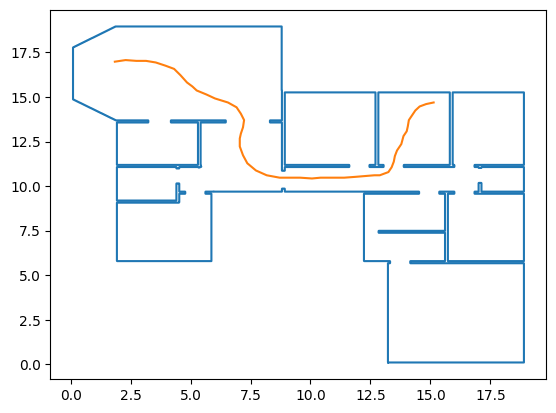

In [5]:
print(env_data["env_name"])
# print(data["paths"]);
# print(data["verts"]);
points = jnp.array(env_data["verts"])
plt.plot(points[:,0],points[:,1])
paths = jnp.array(env_data["paths"][0])
plt.plot(paths[:,0], paths[:,1])

In [6]:
pieces = []
for i in range(len(points) - 1):
    point_1 = points[i]
    point_2 = points[i+1]
    p = b.t3d.transform_from_pos(jnp.concatenate([(point_1 + point_2) /2 , jnp.array([0.0])]))

    dimensions = np.array(jnp.concatenate([jnp.abs(point_1 - point_2) , jnp.array([1.0])]))
    piece = trimesh.creation.box(dimensions, p)

    # print("==============================")
    # print("point_1 ", point_1)
    # print("point_2 ", point_2)
    # print("pose ", p)
    # print("dimensions ", dimensions)
    # print(piece.vertices)
    pieces.append(piece)
map_mesh = trimesh.util.concatenate(pieces)
b.clear()
b.show_trimesh("1", map_mesh)

In [7]:
pose_from_position = lambda p: b.t3d.transform_from_rot_and_pos(b.t3d.rotation_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), -jnp.pi/2), jnp.concatenate([p, jnp.array([0.0])]))
pose_sequence = jax.vmap(pose_from_position)(paths)

In [8]:
b.setup_renderer(intrinsics)
b.RENDERER.add_mesh(map_mesh, center_mesh=False)
b.clear()
b.show_trimesh("1", map_mesh)
for (i,p) in enumerate(pose_sequence):
    b.show_pose(f"2_{i}", p)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 32, 1024)


In [9]:
img = b.RENDERER.render(b.t3d.inverse(pose_sequence[10])[None,...], jnp.array([0]))

In [10]:
cloud = b.t3d.unproject_depth_jit(img[:,:,2], intrinsics)
b.show_cloud("reproject", b.t3d.apply_transform(cloud, pose_sequence[10]).reshape(-1,3))

In [36]:
@genjax.gen
def slam_single_frame(outlier_volume):
    agent_pose = b.genjax.uniform_pose(
        jnp.ones(3) * -30.0,
        jnp.ones(3) * 30.0,
    ) @ f"agent_pose"

    rendered = b.RENDERER.render(
        jnp.linalg.inv(agent_pose)[None,...], jnp.array([0])
    )[...,:3]

   
    variance = genjax.distributions.tfp_uniform(0.00001, 0.1) @ "variance"
    outlier_prob  = genjax.distributions.tfp_uniform(0.00001, 0.1) @ "outlier_prob"
    image = b.genjax.image_likelihood(rendered, variance, outlier_prob, outlier_volume) @ "image"
    return agent_pose, rendered, image

def viz_trace(trace):
    b.clear()
    b.show_trimesh("1", map_mesh)
    b.show_pose(f"pose", trace["agent_pose"])
    b.show_cloud("reproject", b.t3d.apply_transform(trace["image"], trace["agent_pose"]).reshape(-1,3))

In [31]:
enumerator, enumerator_score, enumerator_parallel, enumerator_score_parallel = b.genjax.make_enumerator(["agent_pose"])

In [38]:
key = jax.random.PRNGKey(10)
(key, (_, trace))= slam_single_frame.importance(key,
    genjax.choice_map({
        "agent_pose": pose_sequence[10],
        "variance": 0.0001,
        "outlier_prob": 0.0001,
                      
                      }), (100.0,))
print(trace.get_score())
viz_trace(trace)

362.40518


In [ ]:
pose_sequence

In [40]:
scores = enumerator_score_parallel(trace, key, pose_sequence)
print(scores)

[-645.2825  -656.5941  -668.95386 -681.5995  -668.9459  -667.7372
 -674.64075 -688.5836  -688.5836  -688.5836   362.40518 -688.5836
 -675.84424 -688.5836  -688.5835  -688.5836  -688.5836  -641.80676
 -642.7849  -626.95056 -647.66626 -647.66626 -656.56323 -666.9597
 -688.5836  -688.5836  -688.5836  -688.5836  -688.5836  -669.12634
 -682.85046 -676.41284 -659.7871  -665.1986  -688.5836  -688.5836
 -688.5836  -543.34656 -688.5836  -688.5836  -688.5836  -688.5836
 -667.6234  -668.7528  -688.5836  -667.62415 -672.0051  -669.2936
 -669.2936  -688.58325 -674.52075]
